# WEEK 2

This week we will deal with finding the stars of an open cluster and then plot its HR diagram.

First we import the necessary libraries:

In [45]:
from astroquery.gaia import Gaia
import numpy as np
from scipy.optimize import curve_fit as cf
import matplotlib.pyplot as plt
import astropy

In this tutorial let's take the "Beehive Cluster" as an example.

It's coordinates are RA 8h 40m 24s | Dec +19° 59′ 0″ , we use the following code to then convert it into degrees:

In [46]:
s = '08 40 24 19 59 0'
c = [float(i) for i in s.split()]
ra = c[0]*15 + c[1]/4 + c[2]/240
if c[3] >= 0:
    dec = c[3] + c[4]/60 + c[5]/3600
else:
    dec = c[3] - c[4]/60 - c[5]/3600

print(ra - 0.5, ra + 0.5)
print(dec - 0.5, dec + 0.5)

129.6 130.6
19.483333333333334 20.483333333333334


We also take an interval of ±0.5 degrees so that we can perform rectangular search as can be seen in the query:

In [47]:
query = '''SELECT top 10000
source_id, ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, pm, pmra, pmdec
FROM gaiadr3.gaia_source
WHERE
ra between 129.6 and 130.6 and
dec between 19.48 and 20.48
and parallax_over_error > 5
order by parallax desc
'''
job = Gaia.launch_job_async(query)
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


Now, the distance in parsec(pc) is given by
$$Distance(pc) = \frac{1}{parallax(as)}$$

where the parallax is in arcseconds. However, in the Gaia tables we have parallax in milliarcseconds hence we multiply it by 1000

We then make a scatter plot of Magnitude vs Distance with distance on a logarithmic scale. We will find an overdensity of stars at a certain distance indicating the presence of an open cluster.

Text(0, 0.5, 'Apparent Magnitude')

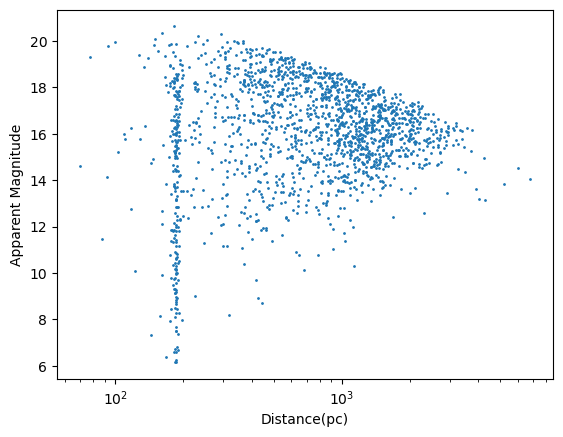

In [48]:
dist = 1000/r['parallax']
plt.scatter(dist, r['phot_g_mean_mag'], s=1)
plt.xscale("log")
plt.xlabel('Distance(pc)')
plt.ylabel('Apparent Magnitude')

We now filter out the stars lying in a distance interval around that overdensity using masks(as shown below) and then make a histogram:

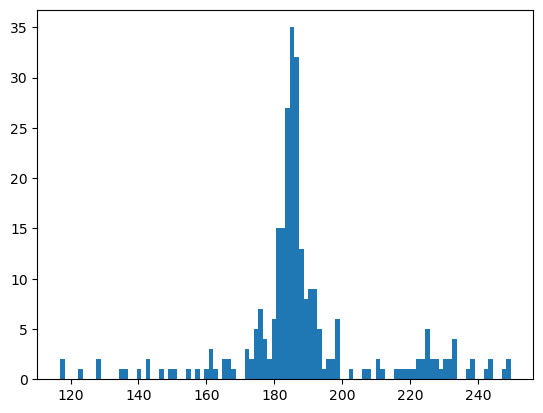

In [62]:
mask = np.logical_and(r['parallax'] > 4, r['parallax'] < 9)
rm = r[mask]
count, dist, bars = plt.hist(1000/rm['parallax'], bins = 100)

dist = np.delete(dist, 1)

Now, for determining which stars are a part of the cluster we will fit a gaussian curve on this histogram and take stars which are within 3 standard deviations of the mean, i.e. in the interval [μ - 3σ, μ + 3σ]

In [63]:
def gaussian(x,mu,sigma,a):
    return a*np.exp(-1*((x-mu)**2)/(2*sigma**2))

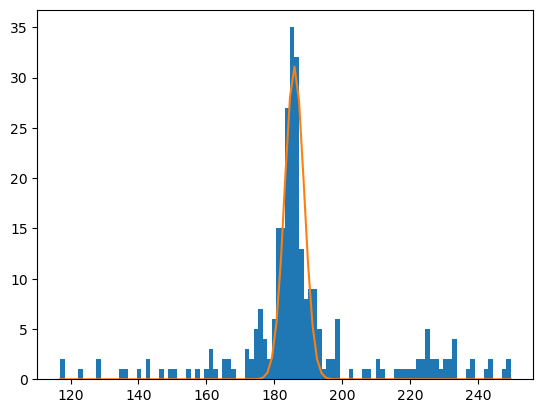

In [64]:
p_opt, p_cov = cf(gaussian, dist, count, (180, 3, 0.1))
count, dist, bars = plt.hist(1000/rm['parallax'], bins = 100)
plt.plot(dist, gaussian(dist, *p_opt))

In [66]:
# p_opt array([185.86285042,   2.85126684,  31.08493846])

After having obtained the fit we then filter the stars within the 3σ interval with a mask and then we make a scatter plot to check clustering in the pmra/pmdec space:

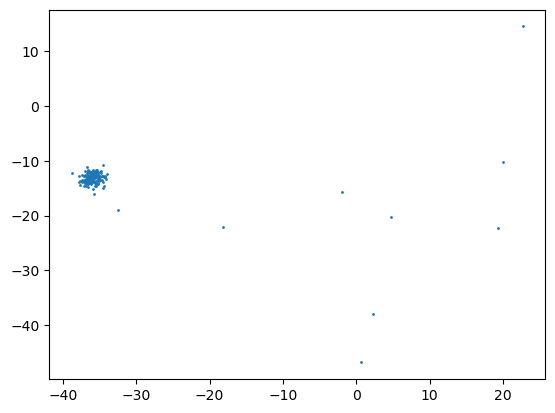

In [67]:
μ = p_opt[0]
σ = p_opt[1]
c_mask = np.logical_and((1000/r['parallax'] > μ - 3*σ), (1000/r['parallax'] < μ + 3*σ))
f = r[c_mask]

plt.scatter(f['pmra'], f['pmdec'], s=1)

We then filter out the stars that lie outside the clustered region to finally obtain the stars which are part of the open cluster:

In [68]:
# plt.axis([-39, -34, -16, -10])
# plt.scatter(f['pmra'], f['pmdec'], s=50)

(-39.0, -34.0, -16.0, -10.0)

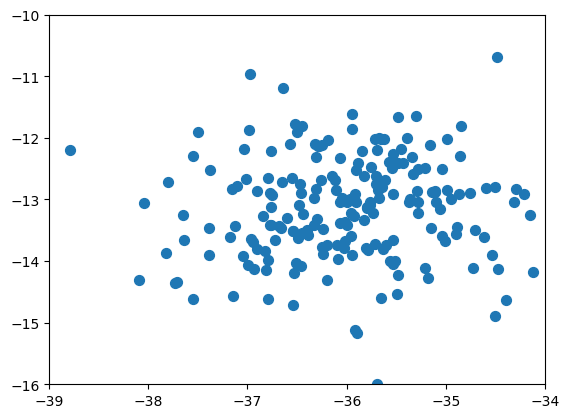

In [69]:
cluster_mask = np.logical_and(np.logical_and((r['pmra']>-39), (r['pmra']<-34)), r['pmdec']>-16, r['pmdec']<-10)
cluster = r[cluster_mask]

plt.scatter(cluster['pmra'], cluster['pmdec'], s=50)
plt.axis([-39, -34, -16, -10])

## HR Diagram

We now finally can make its HR diagram. An HR diagram is the plot between Luminousity and Temperature, which corresponds to the Absolute magnitude and the Difference between BP and RP values

In [70]:
abs_mag = cluster['phot_g_mean_mag']-5*np.log10(100/cluster['parallax'])
bprp = cluster['phot_bp_mean_mag']-cluster['phot_rp_mean_mag']

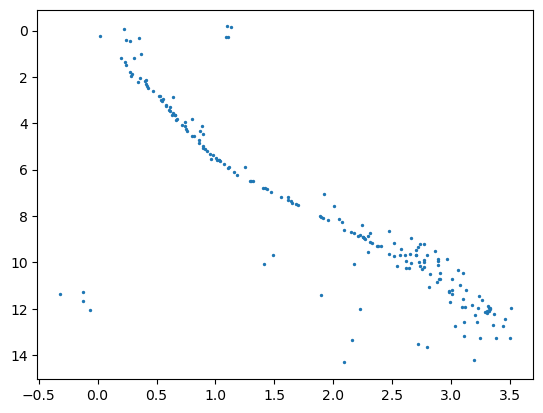

In [71]:
plt.scatter(bprp, abs_mag, s=2)
ax = plt.gca()
ax.invert_yaxis()

Text(0, 0.5, 'Absolute Magnitude')

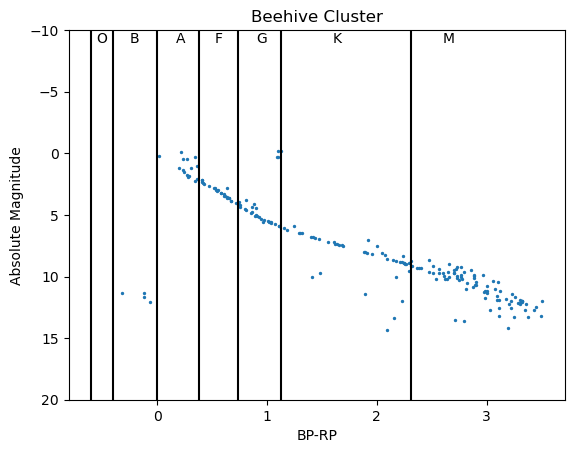

In [72]:
plt.scatter(bprp, abs_mag,s=2,alpha=1)
ax = plt.gca()
ax.invert_yaxis()
stypes = [-0.6, -0.4, 0, 0.38, 0.74, 1.13, 2.31]
plt.vlines(stypes,-10, 20, colors='black')
plt.text(-0.55, -9, 'O')
plt.text(-0.25, -9, 'B')
plt.text(0.17, -9, 'A')
plt.text(0.525, -9, 'F')
plt.text(0.9, -9, 'G')
plt.text(1.6, -9, 'K')
plt.text(2.6, -9, 'M')
plt.ylim(20, -10)



plt.title('Beehive Cluster')
plt.xlabel('BP-RP')
plt.ylabel('Absolute Magnitude')

In [73]:
o_star = cluster[np.logical_and(bprp > -0.6, bprp < -0.4)]
b_star = cluster[np.logical_and(bprp > -0.4, bprp < 0)]
a_star = cluster[np.logical_and(bprp > 0, bprp < 0.38)]
f_star = cluster[np.logical_and(bprp > 0.38, bprp < 0.74)]
g_star = cluster[np.logical_and(bprp > 0.74, bprp < 1.13)]
k_star = cluster[np.logical_and(bprp > 1.13, bprp < 2.31)]
m_star = cluster[np.where(bprp > 2.31)]

print("Percentage of O-Stars: {}".format(len(o_star)*100/len(bprp)))
print("Percentage of B-Stars: {}".format(len(b_star)*100/len(bprp)))
print("Percentage of A-Stars: {}".format(len(a_star)*100/len(bprp)))
print("Percentage of F-Stars: {}".format(len(f_star)*100/len(bprp)))
print("Percentage of G-Stars: {}".format(len(g_star)*100/len(bprp)))
print("Percentage of K-Stars: {}".format(len(k_star)*100/len(bprp)))
print("Percentage of M-Stars: {}".format(len(m_star)*100/len(bprp)))

Percentage of O-Stars: 0.0
Percentage of B-Stars: 1.941747572815534
Percentage of A-Stars: 7.281553398058253
Percentage of F-Stars: 12.135922330097088
Percentage of G-Stars: 14.077669902912621
Percentage of K-Stars: 22.33009708737864
Percentage of M-Stars: 40.77669902912621


# Tasks for this Week

Find atleast 2 open clusters that are within 2000 pc of Earth. That have such clear Gaussian feature above the background count.